In [154]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import pandas as pd
import seaborn as sns
sns.set()
import pandas as pd
import gc
gc.collect()
%matplotlib inline
import matplotlib.pyplot as plt
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')
from tqdm import tqdm

from pyhive import presto
import requests
from requests.auth import HTTPBasicAuth
import pandas as pd
requests.packages.urllib3.disable_warnings()
import matplotlib.pyplot as plt
import datetime as dt
import numpy as np
import gc
gc.collect()
gc.collect()

tqdm.pandas()

231

8

0

/home/ronak/anaconda3/lib/python3.7/site-packages/tqdm/std.py:648: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [1]:
start_date='2020-01-27'
end_date='2020-01-27' 
city='test'
data_file='riderBusy_v1_india_{start_date}_{end_date}.csv'.format(city=city,start_date=start_date,end_date=end_date)

tqdm.pandas()
def download_data(city,start_date,end_date,data_file):
    conn = presto.connect(
        host='10.160.0.62',
        port=8060,
        protocol='http',
        catalog='hive',
        schema='mongodb',
        username='ronak',
        # requests_kwargs=req_kw,
    )
    order_date_query_test = """Select _id as orderid,subtotal,updatedat,services,status,serviceobj_city as city,orderdate from mongodb.orders
where (status ='customerCancelled') and  orderdate BETWEEN '{start_date}' and '{end_date}' LIMiT 10
""".format(city=city,start_date=start_date,end_date=end_date)
    print(order_date_query_test)
    df_order_date_test = pd.read_sql(order_date_query_test, conn)
    df_order_date_test.to_csv(data_file)


download_data(city,start_date,end_date,data_file)

/home/ronak/anaconda3/lib/python3.7/site-packages/tqdm/std.py:648: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [155]:
rider_busy_raw=pd.read_csv(data_file,nrows=10)


def drop_unnamed(df):
    return df.loc[:, ~df.columns.str.contains('^Unnamed')]
rider_busy_raw=drop_unnamed(rider_busy_raw)

In [156]:
rider_busy_raw.head(2)

,orderid,subtotal,updatedat,services,status,city,orderdate
0,5e2ea8ebb73f381c8599ce87,21.0,"[{'_id': ObjectId('5e2ea8eb4102654bbf270ad7'),...","[{'serviceId': '57370b61a6855d70057417d1', 'mi...",customerCancelled,Bangalore,2020-01-27
1,5e2ea8ebcb26a968318c306e,24.0,"[{'_id': ObjectId('5e2ea8eb13d8a74be1a4eaac'),...","[{'serviceId': '574013f14fdf4798208bba26', 'mi...",customerCancelled,Hyderabad,2020-01-27


In [157]:
updated_at_split=rider_busy_raw['updatedat'].progress_apply(lambda x: x.strip('[]'))

100%|██████████| 10/10 [00:00<00:00, 9102.22it/s]


In [168]:
def get_all_new_index(split_list):
    new_string="'status': 'new'"
    all_new_index=[i for i, s in enumerate(split_list) if new_string in s]
    return all_new_index
def get_all_cancelled_index(split_list):
    cancelled_String="'status': 'customerCancelled'"
    cancelled_Index=[i for i, s in enumerate(split_list) if cancelled_String in s]
    return cancelled_Index

import re
def extract_epoch_timestamp(a):
    m = re.search('[0-9]{3,}.[0-9]{1}', a)
    if m:
        found = m.group(0)
        return found
def preprocess_status(x):
    return x.replace('\'',"").replace(' ',"").replace('status:',"")   

def get_start_stop_indices(split_list):
    new_indices=get_all_new_index(split_list)
    cancelled_indices=get_all_cancelled_index(split_list)
    new_cancelled_indices=list(zip(new_indices,cancelled_indices))
    return new_cancelled_indices
def get_all_status_for_range(each_slice):
     if 'status' in each_slice:
        status_index= [i for i, s in enumerate(each_slice.split(',')) if 'status' in s][0]
        first_status=each_slice.split(',')[status_index]
        request_time=float(extract_epoch_timestamp(each_slice.split(',')[status_index+1]))
        return preprocess_status(first_status),request_time
def get_all_status_in_cell(cell):
    split_list= cell.split('{')
    return [list(filter(None.__ne__,[get_all_status_for_range(split_list[curr_index]) \
                                         for curr_index in range(start,stop+1)]))\
                                            for start,stop in get_start_stop_indices(split_list)]

In [170]:
cell=rider_busy_raw['updatedat'].iloc[3]
split_list= cell.split('{')
get_all_status_in_cell

(1, 3)

In [172]:
test=rider_busy_raw['updatedat'].progress_apply(get_all_status_in_cell)
test.iloc[0]



  0%|          | 0/10 [00:00<?, ?it/s]

TypeError: cannot unpack non-iterable int object

In [164]:
test=rider_busy_raw['updatedat'].progress_apply(get_all_status_in_cell)
test.iloc[0]

  0%|          | 0/10 [00:00<?, ?it/s]

TypeError: cannot unpack non-iterable int object

In [159]:
def get_time_difference_before_rider_busy(slice_1):
    rider_busy_indices=[i for i,s in enumerate(slice_1) if 'riderBusy' in s ]
    return [(slice_1[index][1]-slice_1[index-1][1])/1000 for index in rider_busy_indices]

def get_rider_busy_pre_times(status_list_cell):
    list_times=[get_time_difference_before_rider_busy(slice_1) for slice_1 in status_list_cell]
    flat_list = [item for sublist in list_times for item in sublist]
    return flat_list

def get_time_for_each_cell(x):
    status_list_cell=get_all_status_in_cell(x)
    return get_rider_busy_pre_times(status_list_cell)

In [132]:
time_diff=rider_busy_raw['updatedat'].progress_apply(get_time_for_each_cell)

100%|██████████| 149652/149652 [00:06<00:00, 23530.76it/s]


In [142]:
time_diff

0         [28.523]
1               []
2         [27.212]
3               []
4               []
            ...   
149647          []
149648          []
149649          []
149650          []
149651          []
Name: updatedat, Length: 149652, dtype: object

In [141]:
type(time_diff)
time_diff_ser=time_diff.apply(pd.Series).stack().reset_index(drop=True)

pandas.core.series.Series

In [143]:
time_diff_ser.head()

0    28.523
1    27.212
2    25.717
3    27.802
4    28.071
dtype: float64

In [153]:
time_diff_ser.astype(int).describe(percentiles=[0.1,0.2,0.3,0.4,0.6,0.7,0.8,0.9])

count    73929.000000
mean        28.294093
std          8.234443
min        -88.000000
10%         25.000000
20%         26.000000
30%         26.000000
40%         26.000000
50%         27.000000
60%         27.000000
70%         28.000000
80%         28.000000
90%         29.000000
max        168.000000
dtype: float64

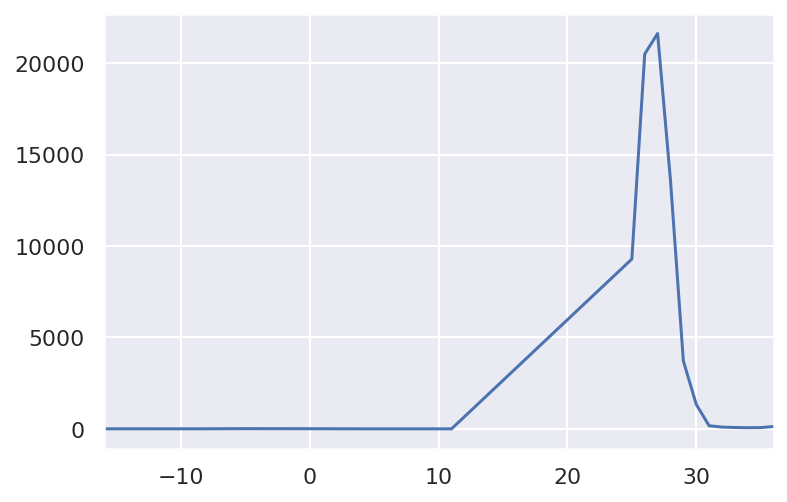

In [149]:
time_diff_ser.astype(int).value_counts().sort_index().iloc[10:30].plot()

In [144]:
time_diff

0         [28.523]
1               []
2         [27.212]
3               []
4               []
            ...   
149647          []
149648          []
149649          []
149650          []
149651          []
Name: updatedat, Length: 149652, dtype: object

In [135]:
time_diff_ser.to_csv('time_diff_before_riderBusy.csv',index=False)

/home/ronak/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  """Entry point for launching an IPython kernel.


In [139]:
time_diff_ser[time_diff_ser<25]

107       4.873
3152      0.003
6681     11.781
16929   -16.348
17372    -5.182
17373    -5.182
17442    -5.161
17449    -5.221
17471   -15.758
17533   -13.534
17935    -5.601
17939    -5.182
17941   -20.397
17942   -21.609
17956   -59.124
17959   -25.675
17963    -5.235
22784   -22.345
22810   -88.097
22839   -20.583
22864   -22.314
22879   -18.863
23843   -23.803
23880   -15.466
23884   -26.560
23918   -17.678
23943     0.001
25634     0.003
32502     0.009
33422    -5.204
49036     0.012
58784    -5.337
59144    -5.243
59280   -13.924
59331    -9.937
62131    -5.239
69076     0.002
69079     0.002
dtype: float64

In [122]:
time_diff

0                  []
1                  []
2            [28.596]
3    [27.492, 26.911]
4                  []
5            [28.153]
6                  []
7            [28.687]
8                  []
9                  []
Name: updatedat, dtype: object

In [ ]:
### get time before status riderbusy


In [ ]:
def get_all_riderBusy_index(split_list):
    rider_rejected_string="'status': 'riderRejected'"
    all_rr_index=[i for i, s in enumerate(split_list) if rider_rejected_string in s]
    return all_rr_index
